# Comparaison de réseaux karstiques
Dans ce notebook, je vais comparer un réseau karstique créé par notre interface avec d'autres karsts connus.
Les données proviennent de 
Collon, P., Bernasconi, D., Vuilleumier, C., & Renard, P. (2021). Corrigendum to “Statistical metrics for the characterization of karst network geometry and topology” [Geomorphology (2017) 283: 122–142] (S0169555X16307796)(10.1016/j.geomorph.2017.01.034). Geomorphology, 389, 107848. https://doi.org/10.1016/j.geomorph.2021.107848

## Préconclusion
En fin de document, on verra que notre karst ne semble pas vraiment leurrer les statistiques.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
from IPython.display import Javascript, display
%matplotlib notebook
mpl.rcParams['figure.dpi'] = 150

On va utiliser ce petit fichier qui rassemble quelques fonctions de récuperation de données (avec Karstnet) et de classification (avec scikit-learn)

In [2]:
from using_karstnet import *

## Données utilisées
Les données de nos karsts sont stockées dans le répertoire "data" à la racine de ce document.
- "Huttes" et "Sakany" sont des données existantes, proposées par Karstnet.
- "Superimposed", "Spongework", "Rectilinear" et "Gorge" sont des données fournies par (Paris, A., Peytavie, A., Guérin, E., Collon, P., & Galin, E. (2021). Synthesizing Geologically Coherent Cave Networks. )
- Tout autre fichier est créé par notre interface.


 This network contains  1  connected components

Graph successfully created from file !



<IPython.core.display.Javascript object>


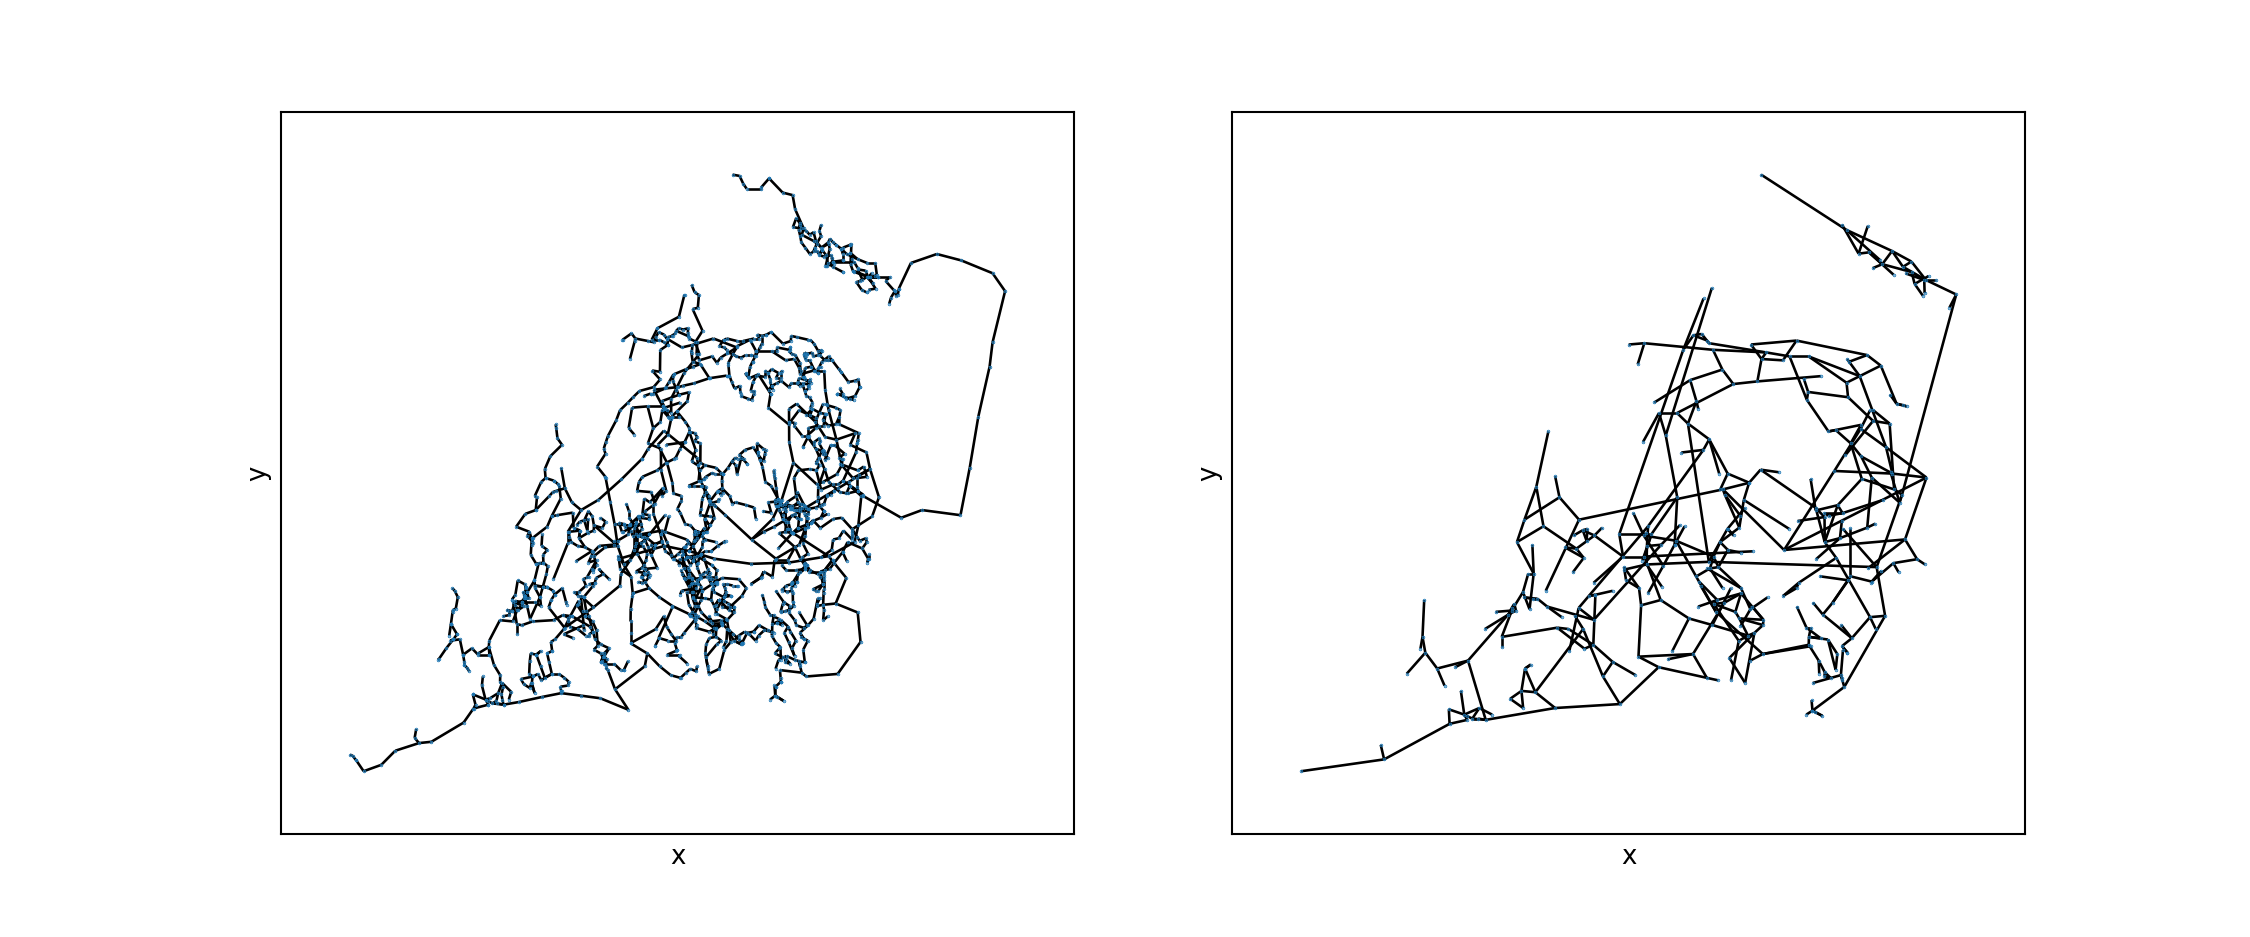

<IPython.core.display.Javascript object>


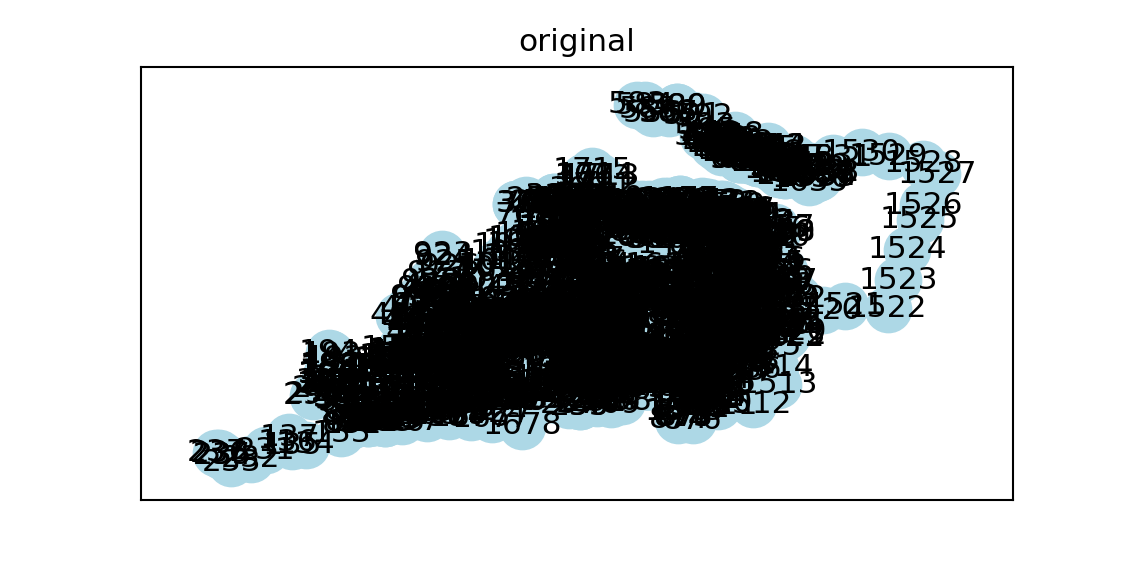

<IPython.core.display.Javascript object>


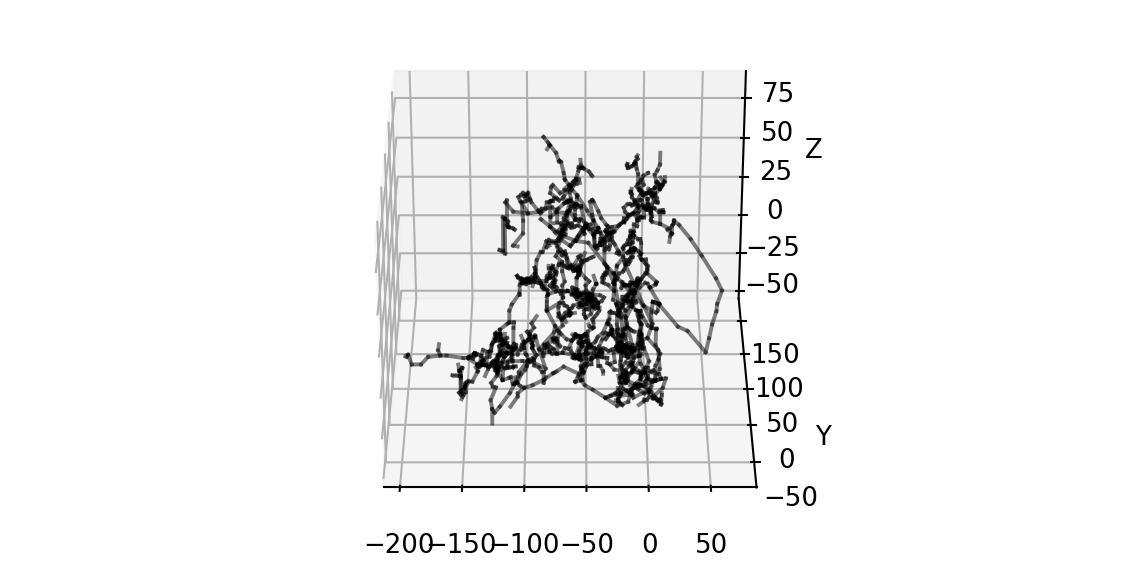

In [3]:
# filename = "data/karst" # Notre karst a nous
# filename = "data/Huttes" # Karst scanné et proposé par P. Collon
filename = "data/Sakany" # Karst scanné et proposé par P. Collon
# filename = "data/superimposed" # Karst généré par A. Peytavie
# filename = "data/spongework" # Karst généré par A. Peytavie
# filename = "data/rectilinear" # Karst généré par A. Peytavie
# filename = "data/gorge" # Karst généré par A. Peytavie
karst = kn.from_nodlink_dat(filename)
karst.plot()
karst.plot2()
karst.plot3()

Quelques statistiques sont disponibles pour l'ensemble du dataset. Nous sommes néanmoins limités à des statistiques qui sont publiées par P. Collon et qui sont accessibles par Karstnet.

Ces données statistiques concernent l'orientation des tunnels, leur longueur, leur tortuosité, et les paramètres de Howard (1970) qui decrivent les graphes associés.  
Les symboles utilisés seront :
- $n$ : Le nombre de noeuds dans la totalité du karst. Je le retire généralement du dataset car il peut considérablement varier selon la méthode d'acquisition utilisée.
- $s$ : Le nombre d'arcs dans le karst. Il est aussi retiré car il dépend complètement de $n$, qui est lui-même ignoré.
- $N$ et $S$ : Le nombre de noeuds et arcs dans le graphe une fois simplifié (ie. en gardant seulement les entrées/sorties et intersections). Ces valeurs sont très corrélées avec les valeurs $n$ et $s$ (corr ~0.87) et une correlation presque parfaite avec le nombre de cycles $Ncycl$ (corr ~1.0).
- $p$ : Le nombre de composants connexes permet de savoir si le réseau est divisé en plusieurs parties pour lesquels aucun lien physique n'a encore été découvert. Nos simulations vont à priori créer un unique composant, je ne pense pas que cette valeur soit pertinente pour nous.
- $N_{cycl}$ : Le nombre de cycles (ou circuits) détéctés dans le réseau.
- $H_o$ : L'entropie de l'orientation du tunnel définie par $H_o = -\sum_{i=1}^{t}{p_i ln_{nbins}(p_i)} $ avec $p_i$ la probabilité d'un arc (pondérée par sa longueur) de tomber dans le *bin* n°$i$ dans l'histogramme des orientations (sur le plan horizontal Nord-Sud/Est-Ouest). Dans son analyse, Collon utilise 18 bins (un bin représentant 10°, les graphes sont non-orientés donc l'orientation est considérée sur 180°). Si tous les arcs vont en ligne droite, $H_o = 0$ et si chaque arc a une direction ayant une distribution uniforme, $H_o = 1$. Il semblerait que l'orientation verticale ne soit pas prise en compte (à verifier dans le code)
- $\overline{len}$ : La longueur moyenne des tunnels prend en considération la distance entre deux points de jonction, c'est-à-dire depuis une entrée/sortie et une intersection, une entrée/sortie vers entrée/sortie ou une intersection vers la prochaine intersection. Un tunnel faisant une grande boucle sans intersection sera donc considéré comme beaucoup plus petit que la réalité.
- $H_{len}$ : L'entropie de la longueur se calcule encore une fois par la formule de Shannon $H_{len} = -\sum_{i=1}^{t}{p_i log_{10}(p_i)}$. Cette fois Collon a choisi 10 bins pour réaliser l'histogramme des longueurs des tunnels. Si tous les tunnels font la même taille, l'entropie est nulle ($H_{len} = 0$) tandis que si les longueurs sont distribuées de manière uniforme, l'entropie vaut 1 ($H_{len} = 1$).
- $CV_{len}$ : Le coefficient de variation des longueurs cherche à quantifier la disparité des mesures dans un réseau. Il est calculé par $CV_{len} = \frac{\sigma_{len}}{\overline{len}}*100$, donc un ratio entre l'écart-type et la moyenne des longueurs.
- $t$ : La tortuosité d'un tunnel est calculé par le ratio entre la longueur réelle du conduit et sa longueur simplifiée (point de jonction vers point de jonction, comme dans le calcul de $\overline{len}$). Soit $l$ la longueur réelle et $d$ la longueur simplifiée, on a une tortuosité $t = \frac{l}{d}$. Ici on utilise la tortuosité moyenne de chaque tunnel pour définir la tortuosité totale du réseau (sans pondérer sur la longueur des tunnels, il me semble). P. Collon semble trouver cette variable biaisée par la méthode d'acquisition et l'équipe de terrain. Néanmoins, l'auteure précise que les chemins formant des circuits sont exclus du calcul. Selon la méthode de génération de karst, les circuits peuvent représenter une très grande partie du réseau (voir "Spongework" généré par A. Peytavie et A. Paris), et donc peut-être biaiser cette valeur dans ce cas.
- $\overline{k}$ : Le degré moyen du graphe, défini par $\overline{k} = \frac{1}{N} \sum_{i=1}^{N}{deg(i)}$.
- $CV_k$ : Le coefficient de variation des degrés des noeuds du graphe est calculé de la même façon que $CV_{len}$, c'est-à-dire $CV_k = \frac{\sigma_{k}}{\overline{k}}*100$.
- $r_k$ : Le coefficient de correlation des degrés est calculé sur la correlation de Pearson par la formule $r_k = \frac{\frac{1}{S}\sum_{j>i}{k_i k_j w_{ij}}-(\frac{1}{S}\sum_{j>i}{\frac{1}{2} (k_i + k_j) w_{ij}})^2}{\frac{1}{S}\sum_{j>i}{(k_i^2 + k_j^2) w_{ij}}-(\frac{1}{S}\sum_{j>i}{\frac{1}{2} (k_i + k_j) w_{ij}})^2}$ avec $k_i$ et $k_j$ les degrés des noeuds de chaque côté d'un arc et $W_{ij}$ la matrice d'adjacence. Une haute valeur $r_k$ décrit un réseau dans lequel les intersections sont connectées à d'autres intersections (eg. Spongework ou Rectilinear) tandis qu'une faible valeur décrirait un réseau dont les noeuds à fort degré sont principalement connectés à des noeuds de faible degré. Étant donné que nous calculons cela sur les graphes simplifiés, les "forts degrés" sont les intersections tandis que les "faibles degrés" ne peuvent qu'être les entrées/sorties. Cette valeur est corrélée avec le degré moyen $\overline{k}$ (corr ~0.79).
- $SPL$ : La longueur moyenne des plus courts chemins est calculé pour chaque paire de vertex dans le graphe simplifié en terme de noeuds (et non en distance métrique). Ce paramètre est fortement corrélé au nombre de noeuds $n$ et le nombre d'arcs $s$ (corr ~0.88 et ~0.88). 
- $CPD$ : Le point central dominant compte le nombre maximum de plus courts chemins qui passent par un noeud du graphe. En réalité ce paramètre est l'entrelacement cental (Betweenness centrality) notée $B$, mais Collon précise que cette valeur est bien trop corrélée au nombre de points et utilise la méthode de Freeman (1977) pour relativiser la valeur. On a alors $B_i^* = \frac{B_i}{N^2 - 3N + 2}$ et le $CPD = \frac{1}{N-1}\sum_i{B_{max}^* - B_j^*}$. On obtient alors des valeurs qui varient généralement entre 0 et 0.6.
- $\alpha$ ("alpha") : La première valeur des paramètre de Howard, $\alpha$ désigne "le ratio du nombre de cycles par rapport au nombre de [cycles] maximum possible pour un nombre de noeuds donnés" (Howard 1970). Il est calculé par $\alpha = \frac{N_{cycl}}{2(N_{jonction} + N_{exterieur}) - 5} = \frac{N_{cycl}}{2N - 5}$ avec $N_jonction$ les intersections et $N_exterieur$ les entrées/sorties.
- $\beta$ ("beta") : Le ratio $\beta$ établit le rapport entre le nombre d'arcs et le nombre de noeuds dans le graphe simplifié. $\beta = \frac{S}{N_jonction + N_exterieur} = \frac{S}{N}$.
- $\gamma$ ("gamma") : Enfin le paramètre $\gamma$ est l'équivalent de $\alpha$ pour les arcs : $\gamma = \frac{S}{2(N_jonction + N_exterieur - 2)} = \frac{S}{2N-6}$
- $D_C$ : Le degré de connectivité est calculé sur $\alpha$, $\beta$ et $\gamma$ par la relation $D_C = \frac{\frac{\alpha}{0.25}+\frac{\beta-1}{0.5}+\frac{\gamma - 0.33}{0.17}}{3}$. Cette valeur est donc très fortement corrélée aux 3 premières (corr ~0.99, ~0.95 et ~0.90 respectivement) ainsi qu'à $\overline{k}$ (corr ~0.95).
- $\theta$ ("theta") : Le coefficient de cycles proposé par Kim et Kim (2005) indique à quel point le graphe est cyclique. On calcule pour chaque noeud $\theta_i = \frac{2}{k_i(k_i - 1)} \sum_{(j, h)}{\frac{1}{L_{jh}^i}}$ avec $L_{jh}^i$ le nombre de cycles passant par i, j et h. Le calcul n'est pas réalisé sur Karstnet, la valeur est fortement corrélée avec les autres paramètres de Howard (corr entre 0.85 avec $\gamma$ et 0.99 avec $\alpha$), donc je ne l'ai pas implémenté.

In [4]:
desired_columns = {
    'KarstName': 1,
    's'        : 0,
    'n'        : 0,
    'N'        : 0,
    'S'        : 0,
    'p'        : 0,
    'Ncycl'    : 0,
    'Ho'       : 1,
    'len'      : 0,
    'Hlen'     : 1,
    'CVlen'    : 1,
    't'        : 1,
    'k'        : 1,
    'CVk'      : 1,
    'rk'       : 0,
    'SPL'      : 0,
    'CPD'      : 1,
    'alpha'    : 0,
    'beta'     : 0,
    'gamma'    : 0,
    'Dc'       : 0,
    'theta'    : 0 # Cannot be set for now
}

Nous n'avons malheureusement pas accès au données 3D des autres karsts, mais seulement des statistiques proposées par P. Collon.  
Nous allons les normaliser afin que toutes les données soient dans l'interval [0;1], ce qui sera plus pratique dans nos comparaisons.

In [5]:
df, scaler = normalizeData(getAllKarstsData(desired_columns), sklearn.preprocessing.MinMaxScaler) # sklearn.preprocessing.QuantileTransformer)
df

,KarstName,Ho,Hlen,CVlen,t,k,CVk,CPD
0,AgenAllwedd,0.868526,0.366667,0.596386,1.000000,0.658537,0.60,0.945455
1,ArphidiaRobinet,0.685259,0.783333,0.114458,0.714286,0.524390,0.56,0.781818
2,Arrestelia,0.641434,0.233333,0.355422,0.547619,0.341463,0.88,0.872727
3,Ceberi,0.900398,0.533333,0.271084,0.357143,0.402439,0.64,0.509091
4,CharentaisHeche,0.956175,0.050000,1.000000,0.309524,0.573171,0.44,0.745455
5,ClydachGorgeCaf1,0.000000,0.716667,0.403614,0.142857,0.000000,0.96,0.981818
6,ClydachGorge OgofCapel,0.581673,0.566667,0.403614,0.547619,0.439024,0.68,0.818182
7,DarenCilau,0.697211,0.233333,0.584337,0.214286,0.463415,0.80,0.890909
8,EglwysFaen,0.800797,0.833333,0.234940,0.047619,0.329268,0.96,1.000000
9,FoussoubieEvent,0.725100,0.466667,0.427711,0.357143,0.500000,0.52,0.818182


Comparé aux autres, voilà notre karst :

In [6]:
karst_data = karstDataToDf(karst, scaler, desired_columns)
pd.DataFrame(karst_data.reshape(1, -1), columns=df.columns)

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd


,KarstName,Ho,Hlen,CVlen,t,k,CVk,CPD
0,myKarst,0.981675,0.511729,0.008987,0.668903,0.787011,0.483229,0.450316


On peut les comparer aux autres réseaux karstiques par une distance Euclidienne, puis voir quel karst s'en rapproche le plus, statistiquement. La valeur des distances ne représente pas grand-chose, mais il peut être interessant de voir le classement des réseaux.

In [7]:
compareToAllKarsts(karst_data, df)

{'Sakany': {'dist': 0.010059573129987705},
 'SiebenHengsteSP2': {'dist': 0.4131289203074731},
 'SiebenHengsteSP1': {'dist': 0.5128443486637755},
 'Lechuguilla': {'dist': 0.5647260070369224},
 'Ceberi': {'dist': 0.5906680671617304},
 'ArphidiaRobinet': {'dist': 0.5996431834708776},
 'Monachou': {'dist': 0.6096100464768973},
 'OjoDelAgua': {'dist': 0.6214406840838705},
 'Shuanghe': {'dist': 0.6333087729666665},
 'GrottesDuRoy': {'dist': 0.6429792454048605},
 'Wakulla': {'dist': 0.6736144587284121},
 'Mammuthohle': {'dist': 0.7179735004555301},
 'FoussoubieGoule': {'dist': 0.729799870293172},
 'FoussoubieEvent': {'dist': 0.747955550180014},
 'SiebenHengsteUpPart': {'dist': 0.7535501955496123},
 'SaintMarcel': {'dist': 0.7696828933839039},
 'Ratasse': {'dist': 0.7755962540687742},
 'OxBelHa': {'dist': 0.7910452018135675},
 'ClydachGorge OgofCapel': {'dist': 0.7928418459476545},
 'SiebenHengsteLargePart': {'dist': 0.8259095600398417},
 'PicDuJer': {'dist': 0.8319354556612787},
 'AgenAllwedd

In [8]:
all_karsts = pd.concat([df, pd.DataFrame(karst_data.reshape(1,-1), columns=list(df))], axis=0)
names = all_karsts["KarstName"]
all_karsts.drop(columns=["KarstName"], inplace=True)

## Clustering

Il n'est pas facile de comparer numériquement ces réseaux, j'ai donc essayé plusieurs méthodes de clustering :
- KMeans, qui cherche les centres d'un nombre de classes prédéfini, qui doit minimiser les distance de chaque karst à sa classe
- DBScan, qui crée des classes si quelques points sont proches, puis fait "grossir" la classe tant que d'autres points sont à proximité.
- Agglomerative Clustering, qui rassemble iterativement les classes selon leur proximité jusqu'à obtenir un nombre prédéfini de classes.

L'affichage des résultats n'est vraiment pas terrible étant donné que nous travaillons sur des données de dimensions 10. Une version plus pratique sera présentée dans la partie "ACP".  
Dans les prochains graphiques, les points représentent les différents karsts du dataset. Notre karst étudié est distingué uniquement par le cercle noir qui l'entoure...

### KMeans
Premièrement, nous allons réaliser un KMeans sur nos données.  
Le principe du KMeans est assez simple : on estime $k$ positions qui vont représenter les centres de nos $k$ classes. On calcule la distance au carré entre chaque point et le centre de classe le plus proche, puis on essaie de déplacer un peu chaque centre pour réduire cette distance totale. On itère un nombre important de fois jusqu'à convergence. Au final, chaque point est associé à la classe représentée par le centre le plus proche de lui.

On va se contenter de 3 classes, mais ce choix est très arbitraire car je ne saurais dire en quoi distinguer des classes de réseaux karstiques. On peut penser à une situation géographique par exemple. Cette classification demanderait donc plus de travail, mais il est pour l'instant uniquement à titre d'essai.

<IPython.core.display.Javascript object>


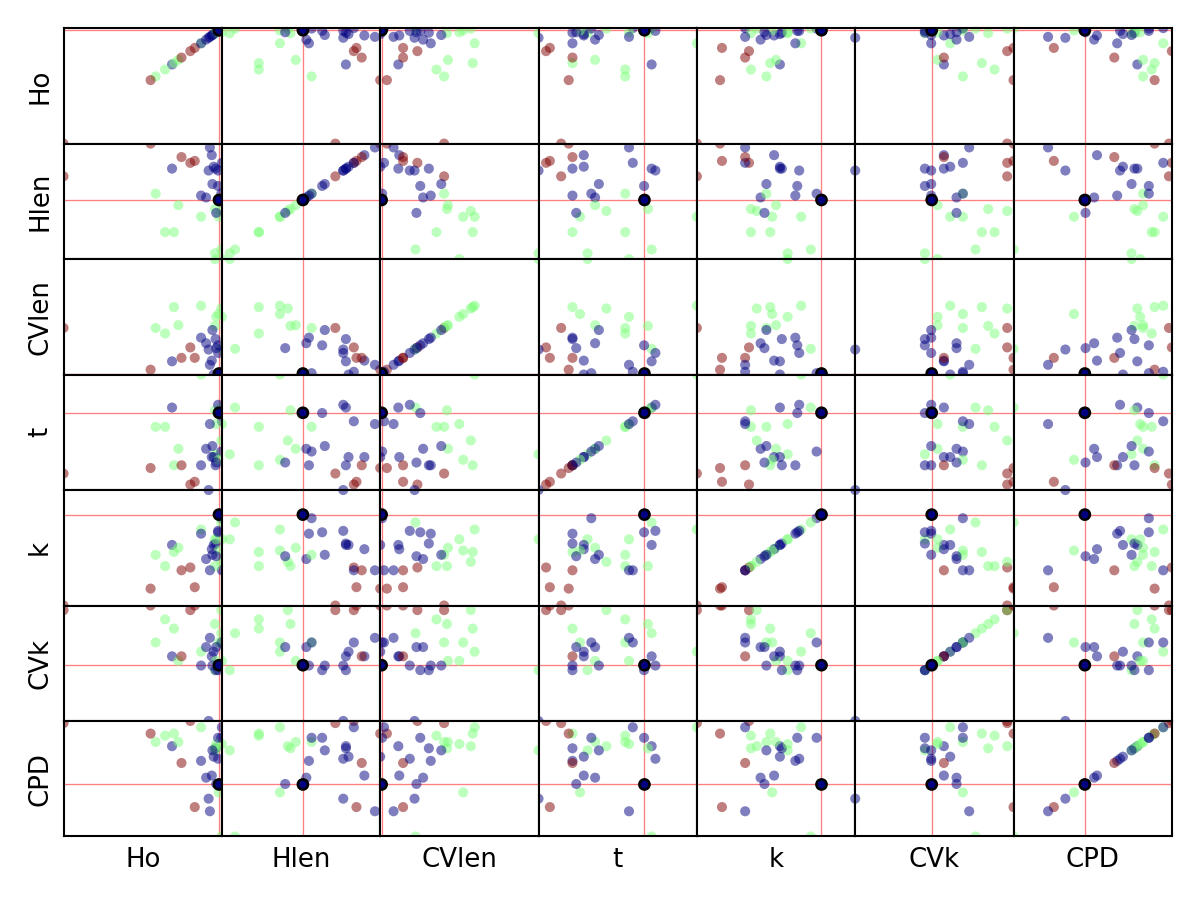

Using Kmeans, our karst looks like :  ['ArphidiaRobinet', 'Ceberi', 'FoussoubieGoule', 'GrottesDuRoy', 'HanSurLesse', 'Lechuguilla', 'Monachou', 'OjoDelAgua', 'OxBelHa', 'Sakany', 'Shuanghe', 'SiebenHengsteUpPart', 'SiebenHengsteSP1', 'SiebenHengsteSP2', 'Wakulla', 'myKarst']


In [9]:
nb_kmeans_classes = 3
kmeans_labels = plotKmeans(all_karsts, nb_kmeans_classes, scaler, names.to_list())
myIndex = kmeans_labels[-1]
print("Using Kmeans, our karst looks like : ", names[kmeans_labels == myIndex].tolist())

### DBScan
Dans cet algorithme de clustering, nous ne définissons pas le nombre de classes à retrouver. On choisit un point au hasard puis lui assignons une classe. On assigne les points qui sont à une distance $d < eps$ à la même classe que ce point. S'ils ont plus de $k$ voisins autour d'eux, ils aussi considéré comme point pivot et peuvent eux aussi "répendre" la classe à ses voisins. Une fois que tous les points pivots ne possèdent plus aucun voisin non-marqué, nous affectons la prochaine classe à un nouveau point non-marqué, puis le même procédé est utilisé. À la fin, les agglomérats de points doivent représenter chaqun une classe, les outliners n'ont pas de classe car ils auront une distance $d > eps$ de chaque autre point.

Nous avons amélioré un peu l'algorithme pour partir d'une distance $eps$ très importante puis réduire ce paramètre jusqu'à ce que au moins un point soit affecté à une nouvelle classe ou considéré comme outlier.  
On espère voir là : 
- si c'est uniquement notre karst qui est "éjecté" du cluster, c'est probablement que notre simulation n'est pas assez réaliste
- si l'un des réseau réel est éjecté en premier, notre réseau peut être considéré comme "possiblement réaliste".
- si notre réseau est classé avec un nouveau groupe de réseaux karstiques, on peut étudier plus profondément la relation entre les réseaux de notre classe pour chercher les similitudes.

<IPython.core.display.Javascript object>


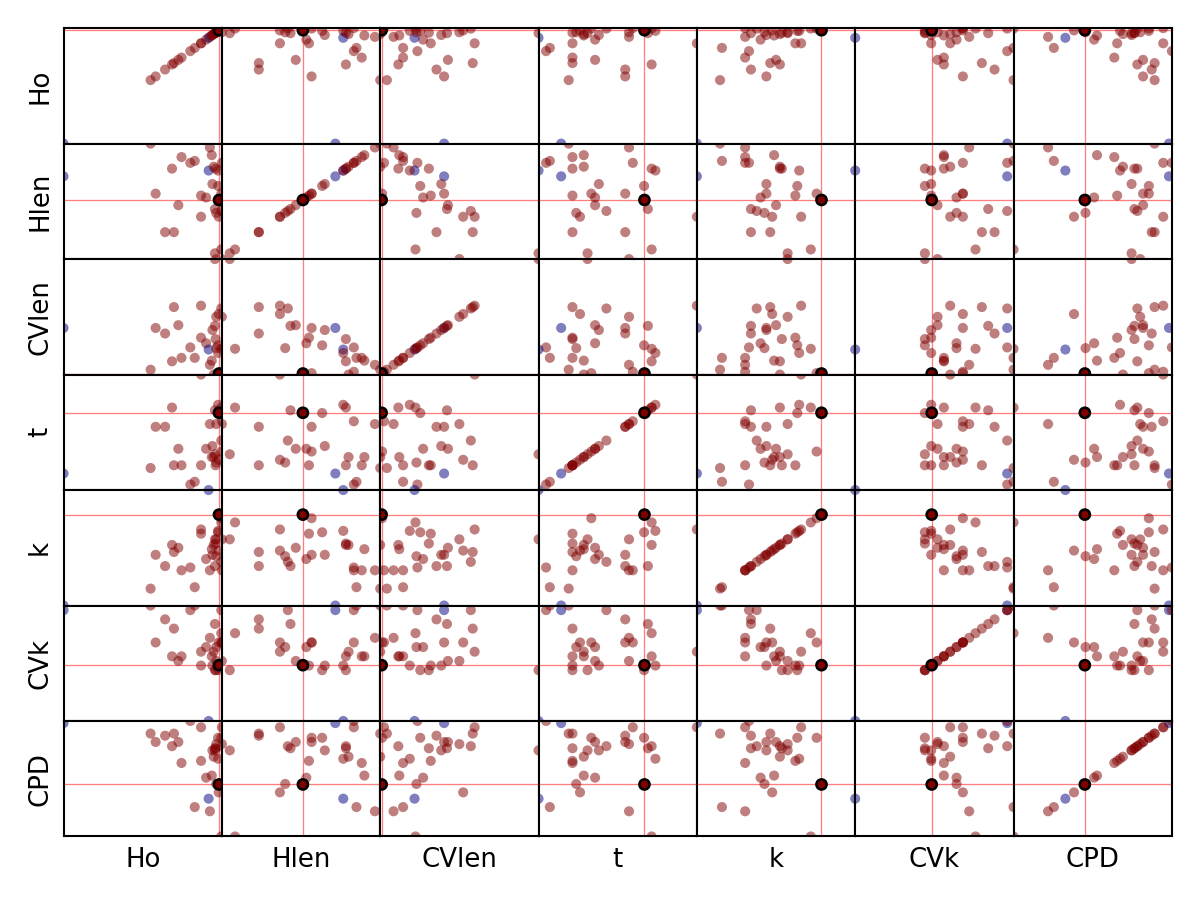

DBScan with eps = 0.7390441470717303 -- 2 classes
Using DBScan, our karst looks like :  ['AgenAllwedd', 'ArphidiaRobinet', 'Arrestelia', 'Ceberi', 'CharentaisHeche', 'ClydachGorge OgofCapel', 'DarenCilau', 'EglwysFaen', 'FoussoubieEvent', 'FoussoubieGoule', 'GenieBraque', 'GrottesDuRoy', 'Krubera', 'Lechuguilla', 'Llangattwg', 'Mammuthohle', 'Monachou', 'OjoDelAgua', 'OxBelHa', 'PicDuJer', 'Ratasse', 'SaintMarcel', 'Sakany', 'Shuanghe', 'SiebenHengsteLargePart', 'SiebenHengsteUpPart', 'SiebenHengsteSP1', 'SiebenHengsteSP2', 'Wakulla', 'myKarst']


In [10]:
dbscan_labels = plotDBScanUntilOutlierExists(all_karsts, scaler, names.to_list())
myIndex = dbscan_labels[-1]
print("Using DBScan, our karst looks like : ", names[dbscan_labels == myIndex].tolist())

### Agglomerative Clustering
Cet algorithme est une méthode itérative de rassembler les données ensemble. Partons du principe de chaque point est représenté par une classe unique. On étudie chaque paire de classe, et on fusionne les deux classes les plus proches ensemble. On répète l'opération jusqu'à obtenir exactement $k$ classes.  

J'éspérais, par l'utilisation de cette méthode, pouvoir observer les similarité à plusieurs niveaux de la "hierarchie" créée par les fusions successives, et ainsi mieux comprendre ce qui rapproche un réseau à un autre une fois affiché en 3D.

<IPython.core.display.Javascript object>


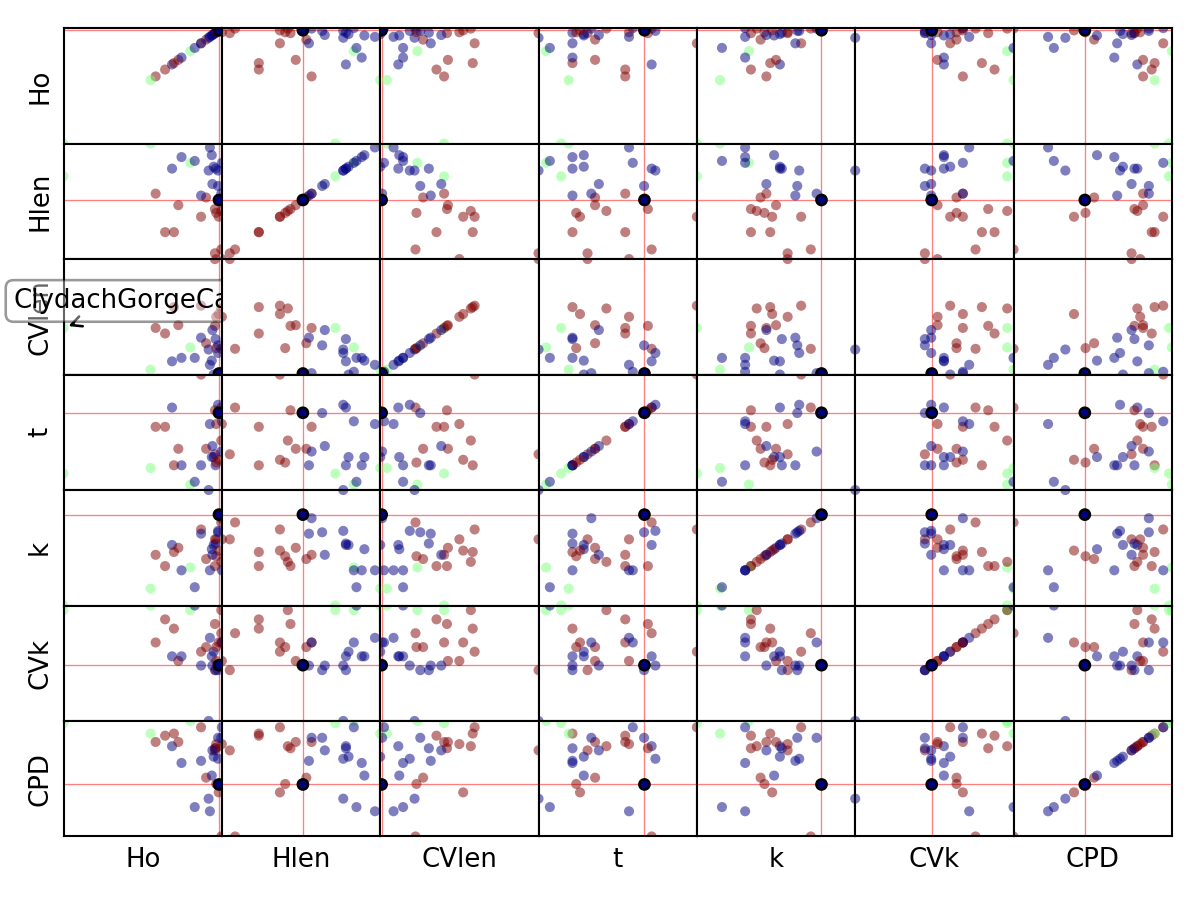

Using AgglomerativeClustering, our karst looks like :  ['ArphidiaRobinet', 'FoussoubieGoule', 'GrottesDuRoy', 'HanSurLesse', 'Lechuguilla', 'Llangattwg', 'Monachou', 'OjoDelAgua', 'OxBelHa', 'PicDuJer', 'Sakany', 'SiebenHengsteUpPart', 'SiebenHengsteSP1', 'SiebenHengsteSP2', 'Wakulla', 'myKarst']


In [11]:
agglomerative_labels = plotAgglomerativeCluster(all_karsts, nb_kmeans_classes, scaler, names.to_list())
myIndex = agglomerative_labels[-1]
print("Using AgglomerativeClustering, our karst looks like : ", names[agglomerative_labels == myIndex].tolist())

## Utilisation d'une ACP
L'exact même procédé sera utilisé dans la suite, mais en passant par une réduction de dimension au préalable.  
Par ce prétraitement, nous souhaitons étudier deux points :
- Voir quels sont les features qui charactérisent la diversité de nos réseaux
- Un affichage plus facilement visible des résultats

Dans un premier temps, on réduit notre dataset à 2 dimensions. La réduction est possiblement trop importante, d'autres tests pourront être réalisés par la suite.

In [12]:
df_pca, pca = decomposeData(getAllKarstsData(desired_columns), number_of_components = 3)
pd.DataFrame(np.array(np.array(pca.components_)/np.array(pca.components_).sum(axis=0)).round(1),
                   columns=df.columns[1:], index=[f"Axis{i+1}" for i in range(pca.n_components)])

,Ho,Hlen,CVlen,t,k,CVk,CPD
Axis1,0.0,44.7,0.8,-0.0,-0.0,-0.0,-0.2
Axis2,1.1,-47.6,0.1,0.4,0.7,0.7,-0.8
Axis3,-0.2,3.9,0.1,0.7,0.3,0.3,2.0


In [13]:
karst_data_pca = karstDataToDf(karst, pca, desired_columns)
compareToAllKarsts(karst_data_pca, df_pca)

all_karsts_pca = pd.concat([df_pca, pd.DataFrame(karst_data_pca.reshape(1,-1), columns=list(df_pca))], axis=0).drop(columns=["KarstName"]).astype(float)

Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd


### KMeans
On va réaliser les mêmes méthodes de clustering qu'avant. Dans un premier temps, on réalise un KMeans pour distribuer nos données en quelques classes.

<IPython.core.display.Javascript object>


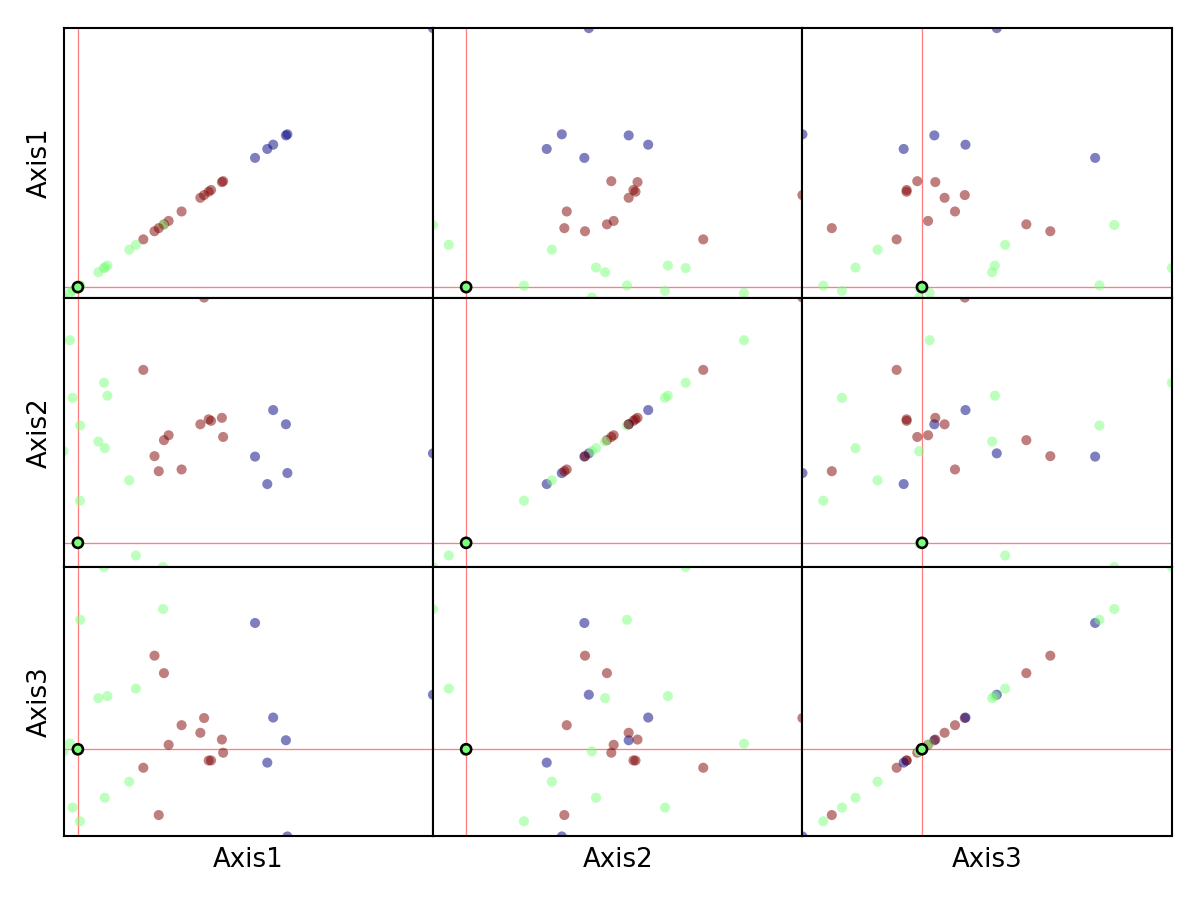

Using Kmeans with PCA, our karst looks like :  ['ArphidiaRobinet', 'GenieBraque', 'GrottesDuRoy', 'HanSurLesse', 'Lechuguilla', 'Llangattwg', 'Mammuthohle', 'Monachou', 'OxBelHa', 'PicDuJer', 'Sakany', 'SiebenHengsteUpPart', 'SiebenHengsteSP2', 'myKarst']


In [14]:
kmeans_labels = plotKmeans(all_karsts_pca, nb_kmeans_classes, pca, names.to_list())
myIndex = kmeans_labels[-1]
print("Using Kmeans with PCA, our karst looks like : ", names[kmeans_labels == myIndex].tolist())

### DBScan
Encore une fois, on va réaliser un clustering en utilisant la méthode du DBScan. 

<IPython.core.display.Javascript object>


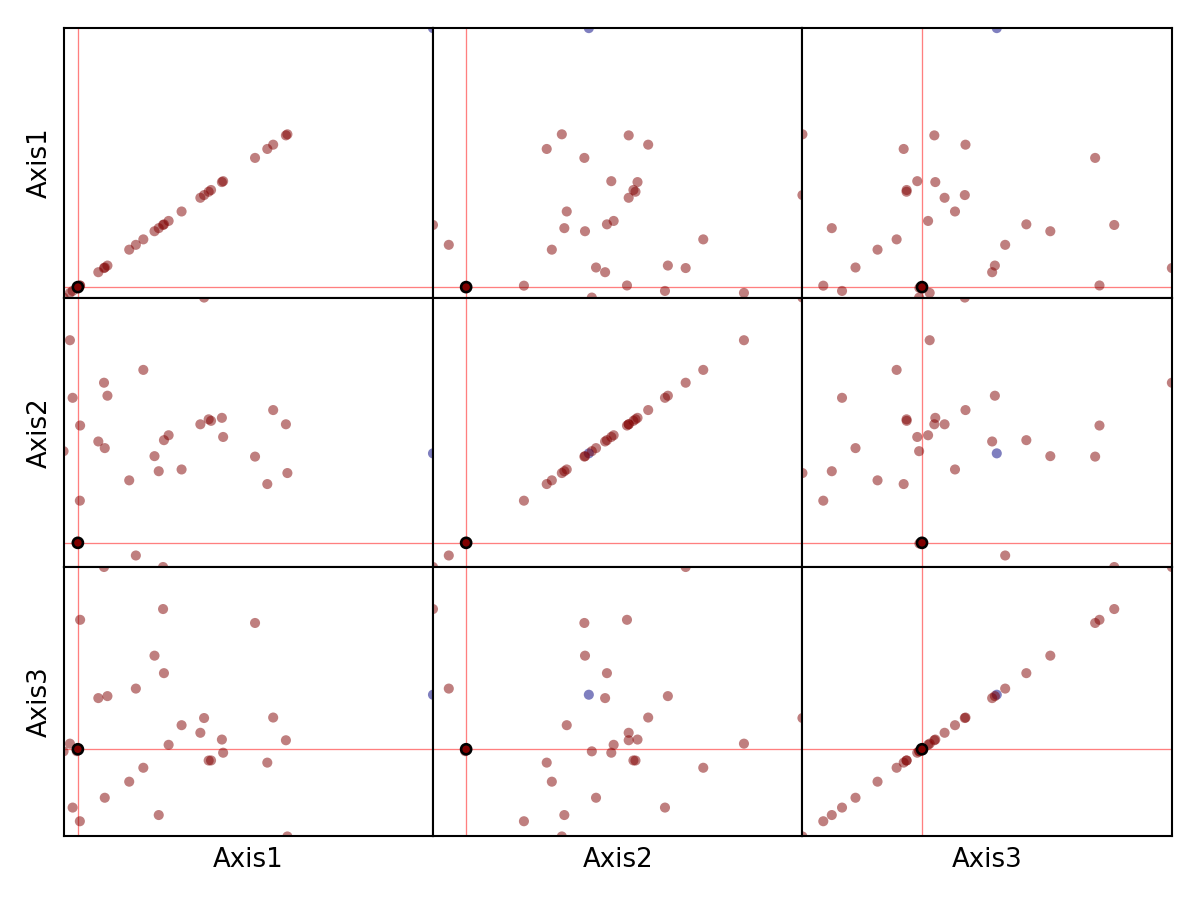

DBScan with eps = 0.6651397323645573 -- 2 classes
Using DBScan with PCA, our karst looks like :  ['AgenAllwedd', 'ArphidiaRobinet', 'Arrestelia', 'Ceberi', 'ClydachGorgeCaf1', 'ClydachGorge OgofCapel', 'DarenCilau', 'EglwysFaen', 'FoussoubieEvent', 'FoussoubieGoule', 'GenieBraque', 'GrottesDuRoy', 'HanSurLesse', 'Krubera', 'Lechuguilla', 'Llangattwg', 'Mammuthohle', 'Monachou', 'OjoDelAgua', 'OxBelHa', 'PicDuJer', 'Ratasse', 'SaintMarcel', 'Sakany', 'Shuanghe', 'SiebenHengsteLargePart', 'SiebenHengsteUpPart', 'SiebenHengsteSP1', 'SiebenHengsteSP2', 'Wakulla', 'myKarst']


In [15]:
dbscan_labels = plotDBScanUntilOutlierExists(all_karsts_pca, pca, names.to_list())
myIndex = dbscan_labels[-1]
print("Using DBScan with PCA, our karst looks like : ", names[dbscan_labels == myIndex].tolist())

### Agglomerative Clustering
Encore une fois, on va passer par un clustering agglomeratif qui fusionne les classes de manière iterative jusqu'à obtenir le nombre de classes demandé.

<IPython.core.display.Javascript object>


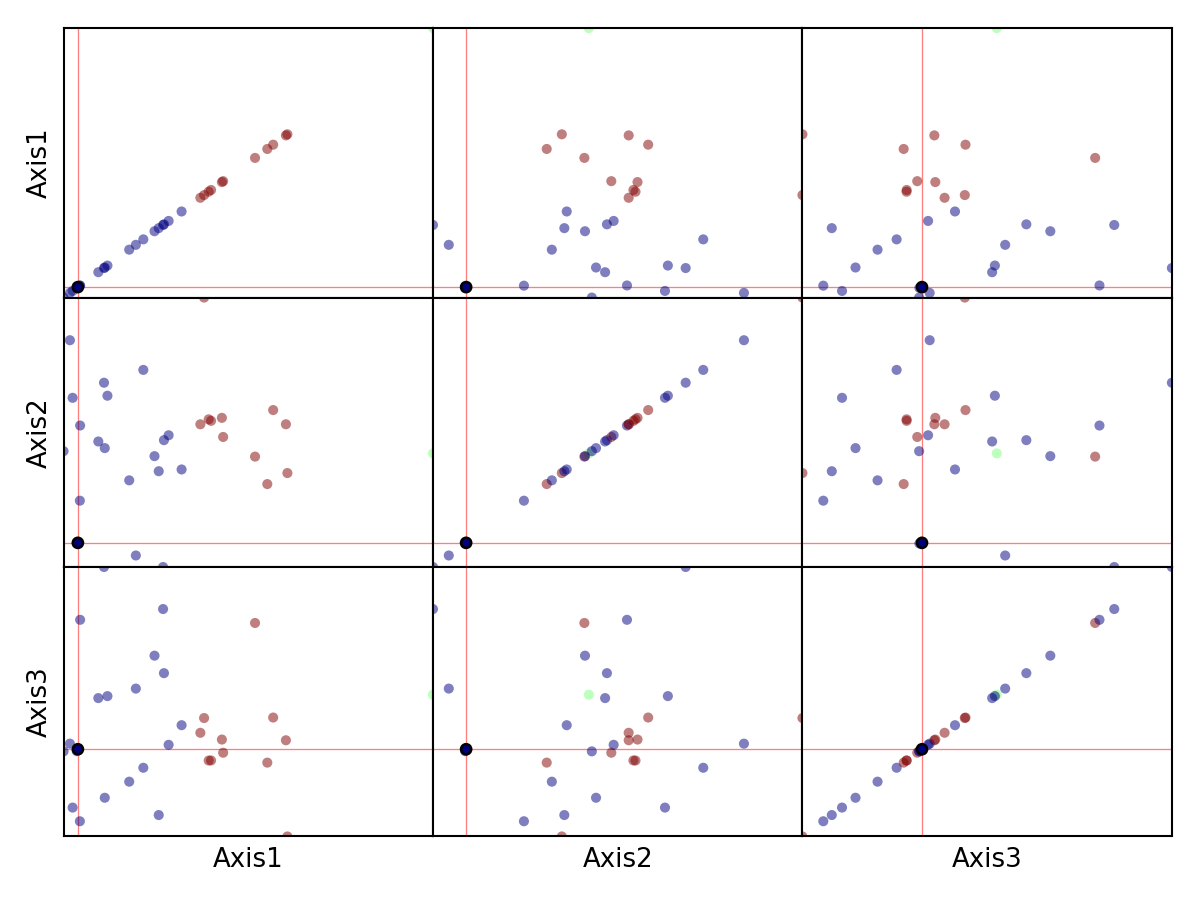

Using AgglomerativeClustering, our karst looks like :  ['ArphidiaRobinet', 'Ceberi', 'EglwysFaen', 'FoussoubieGoule', 'GenieBraque', 'GrottesDuRoy', 'HanSurLesse', 'Lechuguilla', 'Llangattwg', 'Mammuthohle', 'Monachou', 'OjoDelAgua', 'OxBelHa', 'PicDuJer', 'Sakany', 'Shuanghe', 'SiebenHengsteUpPart', 'SiebenHengsteSP1', 'SiebenHengsteSP2', 'myKarst']


In [16]:
agglomerative_labels = plotAgglomerativeCluster(all_karsts_pca, nb_kmeans_classes, pca, names.to_list())
myIndex = agglomerative_labels[-1]
print("Using AgglomerativeClustering, our karst looks like : ", names[agglomerative_labels == myIndex].tolist())

## Conclusion
